### MLP to predit next character in a squence


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import urllib
import random

%matplotlib inline
url = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'

In [ ]:
words = urllib.request.urlopen(url).read().decode("utf-8").splitlines()

In [ ]:
len(words)

32033

In [ ]:
# Vocbulary of characters
chars = sorted(list(set(''.join(words))))
stoi = {ch:i+1 for i,ch in enumerate(chars)}
stoi["."] = 0
itos = {i:ch for ch,i in stoi.items()}

In [ ]:
# Build Dataset
block_size = 3
random.seed(42)
random.shuffle(words)
X, Y = [] , []

for w in words:
  context = [0]*block_size
  for ch in w+'.':
    ix = stoi[ch]
    Y.append(ix)
    X.append(context)

    # New context
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape,Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
# Split dataset
train_size = int(len(X) * 0.8)
dev_size  = int(len(X) * 0.9)

X_tr   = X[:train_size]
X_dev  = X[train_size:dev_size]
X_test = X[dev_size:]

Y_tr   = Y[:train_size]
Y_dev  = Y[train_size:dev_size]
Y_test = Y[dev_size:]

print(f"length of dataset {len(X)}")
print(f"length of training set {len(X_tr)}")
print(f"length of dev set {len(X_dev)}")
print(f"length of test set {len(X_test)}")
print(f"total sum: {len(X_tr)+len(X_dev)+len(X_test)}")

length of dataset 228146
length of training set 182516
length of dev set 22815
length of test set 22815
total sum: 228146


- Using the below architeture as inspiration


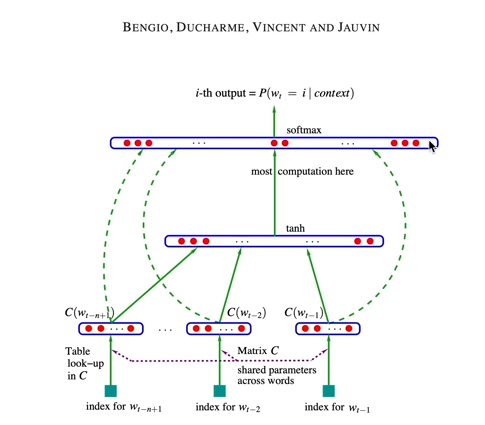


In [ ]:
# Initialize all parameters of the NN
g = torch.Generator().manual_seed(2147483647)
embedding_dim = 10
layer_1_neurons = 200

# Initialize Embeddings Matrix (each row represents a single character's embedding)
C = torch.randn((len(stoi),embedding_dim),generator=g)


# Initialize Layer 1
# block size is the number of characters of the context used as input to NN
# embedding size of each character in embedding dim
# Input to layer = block_size * embedding_dim
W1 = torch.randn(((block_size * embedding_dim),layer_1_neurons),generator=g)
b1 = torch.randn(layer_1_neurons,generator=g)


# Initialize softmax layer (Output layer)
W2 = torch.randn((layer_1_neurons,len(stoi)),generator=g)
b2 = torch.randn(len(stoi),generator=g)

# list the trainable parameters
params = [C,W1,b1,W2,b2]
num_trainable_params = sum(p.nelement() for p in params)
print(f"Trainable parameters : {num_trainable_params}")

Trainable parameters : 11897


In [ ]:
# Indexing of the embedding matrix
print(X_tr[1:3])
print(C[0],C[0],C[5])
print(C[[0,0,5]])
print(C[X_tr[1:3]])

tensor([[ 0,  0, 25],
        [ 0, 25, 21]])
tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046]) tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046]) tensor([ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
        -0.9103, -0.7830])
tensor([[ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
          0.0791,  0.9046],
        [ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
          0.0791,  0.9046],
        [ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
         -0.9103, -0.7830]])
tensor([[[ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,
           0.6049,  0.0791,  0.9046],
         [ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,
           0.6049,  0.0791,  0.9046],
         [-1.2801,  0.0924,  0.1053, -0.3907,  0.0317, -0.5475,  0.8183,
          -

In [ ]:
# Set gradients true for all trainable parameters
for p in params:
  p.requires_grad = True

In [ ]:
lri=[]
lossi=[]
stepi=[]

In [ ]:
epochs = 10000
batch_size = 64
for i in range(epochs):
  # Mini batch indices
  ix = torch.randint(0,X_tr.shape[0],(batch_size,),generator = g)

  # Forward pass
  embd = C[X_tr[ix]]
  # embd = C[X_tr]
  # print(embd.view(-1,(block_size * embedding_dim)).shape)
  # Reshape the embd matrix using view, A view is a very efficient way of
  # reshaping matrices as it does not create any copies and does not change the
  # original matrix, whereas functions like concatenate() and unbind() create
  # additional copies of the matrix and are not efficient

  # Reshapes -1 (auto detect shape by torch and block_size * embedding_dim
  # to make it compatable with the hidden layer neurons )
  h = torch.tanh(embd.view(-1,(block_size * embedding_dim)) @ W1 + b1)
  # print(h.shape)
  logits = h @ W2 + b2
  # print(logits.shape)
  loss = F.cross_entropy(logits,Y_tr[ix])
  # print(loss.item())


  # Backpropagation
  for p in params:
    p.grad = None
  loss.backward()

  for p in params:
    p.data += -0.1 * p.grad

  stepi.append(i)
  lossi.append(loss.item())
print(loss.item())

2.496103286743164


In [ ]:
embd = C[X_tr]
h = torch.tanh(embd.view(-1,(block_size * embedding_dim)) @ W1 + b1)
logits = h @ W2 +b2
train_loss = F.cross_entropy(logits,Y_tr)
print(train_loss.item())

2.246316909790039


In [ ]:
embd = C[X_dev]
h = torch.tanh(embd.view(-1,(block_size * embedding_dim)) @ W1 + b1)
logits = h @ W2 +b2
dev_loss = F.cross_entropy(logits,Y_dev)
print(dev_loss.item())

2.2730560302734375


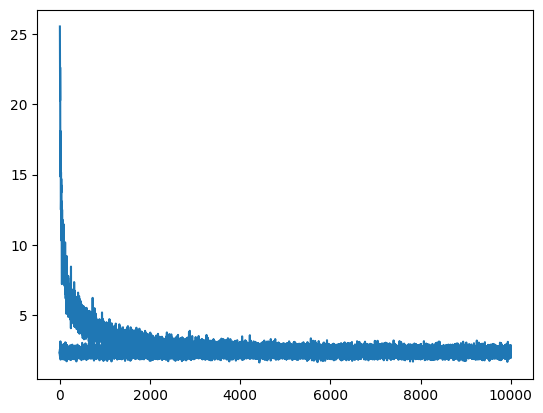

In [ ]:
plt.plot(stepi,lossi)

In [ ]:
# Sampling from the MLP
for _ in range(20):
  ix = 0
  out= []
  input = [0] * block_size

  while True:
    emb = C[input]
    l1_out = torch.tanh((emb.view(1,-1) @ W1 )+ b1)
    l2_out = (l1_out @ W2) + b2
    logits = l2_out.exp()
    probs = F.softmax(logits,dim=1)
    ix = torch.multinomial(probs,num_samples =1,generator=g).item()
    input = input[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print("".join(itos[i] for i in out))


oluwa.
callisson.
elianna.
jaylen.
zailey.
quin.
ulianna.
grettin.
vailey.
tavion.
tavion.
zailey.
rai.
hari.
kailey.
.
oluwa.
paisley.
tavion.
amer.


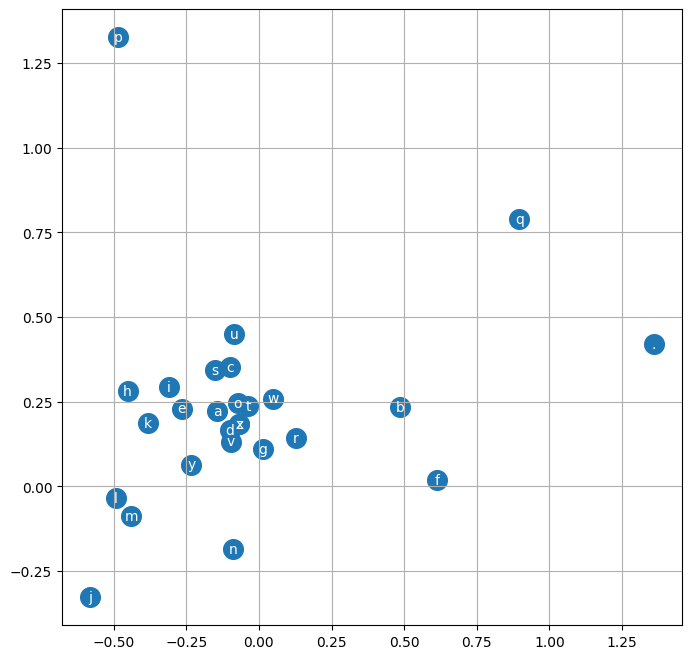

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')